## **Limpieza de datos COVID-19**

### **Librerías**

In [1]:
import pandas as pd
import datetime as dt
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as mplt
from pandas import Grouper
import matplotlib.dates as mdates 
import warnings
warnings.filterwarnings("ignore")

In [2]:
url = 'https://www.datos.gov.co/resource/gt2j-8ykr.json?$offset=' ##conexión con la fuente de datos

In [3]:
consolidated_files = pd.DataFrame() ##tabla donde se almacenarán los registros

#length = 0
#i = 0 ##acumulador para poder establecer el número del registro a leer (funciona junto con offset)

##En cada nueva iteración se leen 1000 registros (este es el máximo por iteración) comenzando por el último encontrado para no repetir
#while length % 1000 == 0: ##mientras la cantidad de registros dividido mil no deje residuo significa que aún hay registros por extraer
#    offset = str(i*1000) ##offset indica en qué registro comenzar
#    df = pd.read_json(url+offset)
#    consolidated_files = consolidated_files.append(df, sort=False) ##se agregan los nuevos datos a la tabla sin borrar los anteriores
#    length = len(consolidated_files) ##se actualiza la cantidad de registros en la tabla para ser evaluada en la próxima iteración
#    i = i + 1
#    #print('Cargados ' + str(length) + ' registros') ##validador en pantalla de ejecución
#del df
#print('Cargue completado: ' + str(length) + ' registros') ##validar finalización del cargue de los registros
#consolidated_files.to_csv(r'..\Datos\CasosPositivosCOVID19_Colombia.csv')

consolidated_files = pd.read_csv("../Datos/CasosPositivosCOVID19_Colombia.csv", sep = ',')



### **Descripción metadata**

**Ciudad de ubicación:** por seguridad de las personas, algunos datos serán limitados evitando así la exposición y posible identificación en determinados municipios. 

**Fecha de muerte:** fecha de muerte del paciente.

**Fecha recuperado:** fecha recuperado.

**Fecha reporte Web:** fecha reporte Web.

**Fecha de diagnóstico:** fecha de confirmación por laboratorio.

**Id de caso:** identificador de caso.

**Atención:** * corresponde a muertes no relacionadas con COVID-19, aún si eran casos activos ** Hay pacientes recuperados para COVID-19, que pueden permanecer en hospitalización por otras comorbilidades.

**Edad:** edad del paciente.

**Sexo:** sexo del paciente.


#### **Transformación de datos**

In [4]:
consolidated_files['fecha_recuperado'] = pd.to_datetime(consolidated_files['fecha_recuperado']).dt.tz_localize(None) ## Se cambia el tipo de dato de objeto a datatime
consolidated_files['fecha_reporte_web'] = pd.to_datetime(consolidated_files['fecha_reporte_web']).dt.tz_localize(None) 
consolidated_files['fecha_de_muerte'] = pd.to_datetime(consolidated_files['fecha_de_muerte']).dt.tz_localize(None)

In [5]:
data_filtrada_ciudades = consolidated_files.loc[consolidated_files['ciudad_de_ubicaci_n'].isin(['Medellín','Bogotá D.C.','Cali','Barranquilla','Cartagena de Indias'])]
data_filtrada_ciudades ## Se filtran las ciudades principales de trabajo

,Unnamed: 0,id_de_caso,fecha_de_notificaci_n,c_digo_divipola,ciudad_de_ubicaci_n,departamento,atenci_n,edad,sexo,tipo,...,fis,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_de_muerte
0,0,1,2020-03-02T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,...,2020-02-27T00:00:00.000,2020-03-06T00:00:00.000,2020-03-13,2020-03-06,PCR,11,380.0,Otro,NaN,NaT
2,2,3,2020-03-07T00:00:00.000,5001,Medellín,Antioquia,Recuperado,50,F,Importado,...,2020-02-29T00:00:00.000,2020-03-09T00:00:00.000,2020-03-15,2020-03-09,PCR,5,724.0,Otro,NaN,NaT
3,3,4,2020-03-09T00:00:00.000,5001,Medellín,Antioquia,Recuperado,55,M,Relacionado,...,2020-03-06T00:00:00.000,2020-03-11T00:00:00.000,2020-03-26,2020-03-11,PCR,5,NaN,Otro,NaN,NaT
4,4,5,2020-03-09T00:00:00.000,5001,Medellín,Antioquia,Recuperado,25,M,Relacionado,...,2020-03-08T00:00:00.000,2020-03-11T00:00:00.000,2020-03-23,2020-03-11,PCR,5,NaN,Otro,NaN,NaT
6,6,7,2020-03-08T00:00:00.000,13001,Cartagena de Indias,Cartagena D.T. y C.,Recuperado,85,F,Importado,...,2020-03-02T00:00:00.000,2020-03-11T00:00:00.000,2020-03-17,2020-03-11,PCR,13,840.0,Otro,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513647,647,513688,2020-08-09T00:00:00.000,76001,Cali,Valle del Cauca,Casa,44,M,En estudio,...,2020-08-05T00:00:00.000,2020-08-20T00:00:00.000,NaT,2020-08-20,NaN,76,NaN,NaN,NaN,NaT
513648,648,513689,2020-08-09T00:00:00.000,76001,Cali,Valle del Cauca,Casa,20,M,En estudio,...,2020-08-05T00:00:00.000,2020-08-20T00:00:00.000,NaT,2020-08-20,NaN,76,NaN,NaN,NaN,NaT
513649,649,513690,2020-08-09T00:00:00.000,76001,Cali,Valle del Cauca,Casa,33,M,En estudio,...,2020-08-05T00:00:00.000,2020-08-20T00:00:00.000,NaT,2020-08-20,NaN,76,NaN,NaN,NaN,NaT
513656,656,513697,2020-08-09T00:00:00.000,76001,Cali,Valle del Cauca,Casa,18,M,En estudio,...,2020-08-05T00:00:00.000,2020-08-20T00:00:00.000,NaT,2020-08-20,NaN,76,NaN,NaN,NaN,NaT


### **Casos confirmados**

In [6]:
data_confirmados = data_filtrada_ciudades.loc[data_filtrada_ciudades['atenci_n'].isin(['Fallecido','Recuperado','Casa','Hospital','N/A','Hospital UCI'])] ## se filtra la columna atenci_n 

In [7]:
data_confirmados.dropna(axis=0, how='all', inplace = True)  ## Se eliminan los vacíos
data_confirmados

,Unnamed: 0,id_de_caso,fecha_de_notificaci_n,c_digo_divipola,ciudad_de_ubicaci_n,departamento,atenci_n,edad,sexo,tipo,...,fis,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_de_muerte
0,0,1,2020-03-02T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,...,2020-02-27T00:00:00.000,2020-03-06T00:00:00.000,2020-03-13,2020-03-06,PCR,11,380.0,Otro,NaN,NaT
2,2,3,2020-03-07T00:00:00.000,5001,Medellín,Antioquia,Recuperado,50,F,Importado,...,2020-02-29T00:00:00.000,2020-03-09T00:00:00.000,2020-03-15,2020-03-09,PCR,5,724.0,Otro,NaN,NaT
3,3,4,2020-03-09T00:00:00.000,5001,Medellín,Antioquia,Recuperado,55,M,Relacionado,...,2020-03-06T00:00:00.000,2020-03-11T00:00:00.000,2020-03-26,2020-03-11,PCR,5,NaN,Otro,NaN,NaT
4,4,5,2020-03-09T00:00:00.000,5001,Medellín,Antioquia,Recuperado,25,M,Relacionado,...,2020-03-08T00:00:00.000,2020-03-11T00:00:00.000,2020-03-23,2020-03-11,PCR,5,NaN,Otro,NaN,NaT
6,6,7,2020-03-08T00:00:00.000,13001,Cartagena de Indias,Cartagena D.T. y C.,Recuperado,85,F,Importado,...,2020-03-02T00:00:00.000,2020-03-11T00:00:00.000,2020-03-17,2020-03-11,PCR,13,840.0,Otro,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513647,647,513688,2020-08-09T00:00:00.000,76001,Cali,Valle del Cauca,Casa,44,M,En estudio,...,2020-08-05T00:00:00.000,2020-08-20T00:00:00.000,NaT,2020-08-20,NaN,76,NaN,NaN,NaN,NaT
513648,648,513689,2020-08-09T00:00:00.000,76001,Cali,Valle del Cauca,Casa,20,M,En estudio,...,2020-08-05T00:00:00.000,2020-08-20T00:00:00.000,NaT,2020-08-20,NaN,76,NaN,NaN,NaN,NaT
513649,649,513690,2020-08-09T00:00:00.000,76001,Cali,Valle del Cauca,Casa,33,M,En estudio,...,2020-08-05T00:00:00.000,2020-08-20T00:00:00.000,NaT,2020-08-20,NaN,76,NaN,NaN,NaN,NaT
513656,656,513697,2020-08-09T00:00:00.000,76001,Cali,Valle del Cauca,Casa,18,M,En estudio,...,2020-08-05T00:00:00.000,2020-08-20T00:00:00.000,NaT,2020-08-20,NaN,76,NaN,NaN,NaN,NaT


In [8]:
data_1 = data_confirmados[['fecha_reporte_web','ciudad_de_ubicaci_n']] 
data_1 ## Se extraen las columnas de data_confirmados

,fecha_reporte_web,ciudad_de_ubicaci_n
0,2020-03-06,Bogotá D.C.
2,2020-03-09,Medellín
3,2020-03-11,Medellín
4,2020-03-11,Medellín
6,2020-03-11,Cartagena de Indias
...,...,...
513647,2020-08-20,Cali
513648,2020-08-20,Cali
513649,2020-08-20,Cali
513656,2020-08-20,Cali


In [9]:
dataset_confirmados = pd.DataFrame({'conteo_confirmados' : data_1.groupby( ['fecha_reporte_web','ciudad_de_ubicaci_n'] ).size()}).reset_index()
dataset_confirmados ## Se convierte a dataframe, se hace agrupación para confirmados y se hace el conteo.

,fecha_reporte_web,ciudad_de_ubicaci_n,conteo_confirmados
0,2020-03-06,Bogotá D.C.,1
1,2020-03-09,Medellín,1
2,2020-03-11,Bogotá D.C.,2
3,2020-03-11,Cartagena de Indias,1
4,2020-03-11,Medellín,2
...,...,...,...
771,2020-08-20,Barranquilla,165
772,2020-08-20,Bogotá D.C.,3205
773,2020-08-20,Cali,992
774,2020-08-20,Cartagena de Indias,65


#### **Casos fallecidos**

In [10]:
data_fallecidos = data_filtrada_ciudades.loc[data_filtrada_ciudades['atenci_n'].isin(['Fallecido'])]
data_fallecidos ## Se filtran los fallecidos

,Unnamed: 0,id_de_caso,fecha_de_notificaci_n,c_digo_divipola,ciudad_de_ubicaci_n,departamento,atenci_n,edad,sexo,tipo,...,fis,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_de_muerte
151,151,152,2020-03-18T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Fallecido,65,M,Importado,...,2020-03-10T00:00:00.000,2020-03-20T00:00:00.000,NaT,2020-03-20,NaN,11,840.0,Otro,NaN,2020-04-05
152,152,153,2020-03-18T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Fallecido,53,F,Relacionado,...,2020-03-18T00:00:00.000,2020-03-20T00:00:00.000,NaT,2020-03-20,NaN,11,NaN,Otro,NaN,2020-04-06
196,196,197,2020-03-13T00:00:00.000,13001,Cartagena de Indias,Cartagena D.T. y C.,Fallecido,58,M,Relacionado,...,2020-03-06T00:00:00.000,2020-03-16T00:00:00.000,NaT,2020-03-16,NaN,13,NaN,Otro,NaN,2020-03-16
231,231,232,2020-03-20T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Fallecido,59,F,Relacionado,...,2020-03-13T00:00:00.000,2020-03-22T00:00:00.000,NaT,2020-03-22,NaN,11,NaN,Otro,NaN,2020-03-26
249,249,250,2020-03-23T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Fallecido,76,M,En estudio,...,2020-03-10T00:00:00.000,2020-03-23T00:00:00.000,NaT,2020-03-23,NaN,11,NaN,Otro,NaN,2020-03-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474224,224,474265,2020-08-14T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Fallecido,60,M,En estudio,...,2020-08-06T00:00:00.000,2020-08-16T00:00:00.000,NaT,2020-08-17,NaN,11,NaN,NaN,NaN,2020-08-20
474296,296,474337,2020-08-11T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Fallecido,77,M,En estudio,...,2020-08-11T00:00:00.000,2020-08-16T00:00:00.000,NaT,2020-08-17,NaN,11,NaN,NaN,NaN,2020-08-18
474313,313,474354,2020-08-13T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Fallecido,65,M,En estudio,...,2020-08-13T00:00:00.000,2020-08-16T00:00:00.000,NaT,2020-08-17,NaN,11,NaN,NaN,NaN,2020-08-17
474597,597,474638,2020-08-12T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Fallecido,71,M,En estudio,...,2020-08-12T00:00:00.000,2020-08-15T00:00:00.000,NaT,2020-08-17,NaN,11,NaN,NaN,NaN,2020-08-13


In [11]:
data_fallecidos.dropna(axis=0, how='all', inplace = True)  ## Se eliminan los vacíos

In [12]:
data_2 = data_fallecidos[['fecha_reporte_web','ciudad_de_ubicaci_n']] ## Se obtienen las columnas de interés para fallecidos

In [13]:
dataset_fallecidos = pd.DataFrame({'conteo_fallecidos' : data_2.groupby( ['fecha_reporte_web','ciudad_de_ubicaci_n'] ).size()}).reset_index()## Se convierte a dataframe, se hace agrupación para fallecidos y se hace el conteo.
dataset_fallecidos 

,fecha_reporte_web,ciudad_de_ubicaci_n,conteo_fallecidos
0,2020-03-16,Cartagena de Indias,1
1,2020-03-20,Bogotá D.C.,2
2,2020-03-22,Bogotá D.C.,1
3,2020-03-23,Bogotá D.C.,2
4,2020-03-23,Cali,1
...,...,...,...
554,2020-08-16,Medellín,11
555,2020-08-17,Barranquilla,1
556,2020-08-17,Bogotá D.C.,27
557,2020-08-17,Cali,12


#### **Casos recuperados**

In [14]:
data_recuperado = data_filtrada_ciudades.loc[data_filtrada_ciudades['atenci_n'].isin(['Recuperado'])]## se filtra para obtener los recuperados

In [15]:
data_recuperado.dropna(axis=0, how='all', inplace = True)## Se eliminan los vacíos

In [16]:
data_3 = data_recuperado[['fecha_reporte_web','ciudad_de_ubicaci_n']] ## Se obtienen las columnas de interés para recuperados

In [17]:
dataset_recuperado = pd.DataFrame({'conteo_recuperado' : data_3.groupby( ['fecha_reporte_web','ciudad_de_ubicaci_n'] ).size()}).reset_index()## Se convierte a dataframe, se hace agrupación para recuperados y se hace el conteo.
dataset_recuperado

,fecha_reporte_web,ciudad_de_ubicaci_n,conteo_recuperado
0,2020-03-06,Bogotá D.C.,1
1,2020-03-09,Medellín,1
2,2020-03-11,Bogotá D.C.,2
3,2020-03-11,Cartagena de Indias,1
4,2020-03-11,Medellín,2
...,...,...,...
761,2020-08-18,Cali,1
762,2020-08-18,Cartagena de Indias,6
763,2020-08-18,Medellín,9
764,2020-08-19,Bogotá D.C.,223


In [18]:
df_filtrado = data_filtrada_ciudades[['fecha_reporte_web','ciudad_de_ubicaci_n']] ## Se obtienen las columnas de interés para los joins que se realizarán

In [19]:
df_filtrado = df_filtrado.drop_duplicates() ## Se eliminan los duplicados

In [20]:
new_df = pd.merge(df_filtrado, dataset_confirmados,  how='left', left_on=['fecha_reporte_web','ciudad_de_ubicaci_n'], right_on = ['fecha_reporte_web','ciudad_de_ubicaci_n'])
## Se hace left join de las tablas de df_filtrado y dataset_confirmados

In [21]:
new_df1 = pd.merge(new_df, dataset_fallecidos,  how='left', left_on=['fecha_reporte_web','ciudad_de_ubicaci_n'], right_on = ['fecha_reporte_web','ciudad_de_ubicaci_n'])
## Se hace left join de las tablas de new_df y dataset_fallecidos

In [22]:
new_df2 = pd.merge(new_df1, dataset_recuperado,  how='left', left_on=['fecha_reporte_web','ciudad_de_ubicaci_n'], right_on = ['fecha_reporte_web','ciudad_de_ubicaci_n'])
## Se hace left join de las tablas de new_df1 y dataset_recuperado

In [23]:
new_df2['conteo_confirmados'].fillna(0, inplace=True) ## Se llenan con ceros los campos de los conteos los que tienen NaN
new_df2['conteo_fallecidos'].fillna(0, inplace=True)
new_df2['conteo_recuperado'].fillna(0, inplace=True)
new_df2

,fecha_reporte_web,ciudad_de_ubicaci_n,conteo_confirmados,conteo_fallecidos,conteo_recuperado
0,2020-03-06,Bogotá D.C.,1,0.0,1.0
1,2020-03-09,Medellín,1,0.0,1.0
2,2020-03-11,Medellín,2,0.0,2.0
3,2020-03-11,Cartagena de Indias,1,0.0,1.0
4,2020-03-11,Bogotá D.C.,2,0.0,2.0
...,...,...,...,...,...
771,2020-08-20,Cali,992,0.0,0.0
772,2020-08-20,Barranquilla,165,0.0,0.0
773,2020-08-20,Medellín,419,0.0,0.0
774,2020-08-20,Cartagena de Indias,65,0.0,0.0


#### **Casos activos**

In [24]:
data_activos= data_filtrada_ciudades.loc[data_filtrada_ciudades['atenci_n'].isin(['Casa','Hospital','Hospital UCI'])] 

In [25]:
data_activos.dropna(axis=0, how='all', inplace = True)  ## Se eliminan los vacíos

In [26]:
data_4 = data_activos[['fecha_reporte_web','ciudad_de_ubicaci_n']] 

In [27]:
dataset_activos = pd.DataFrame({'casos_activos' : data_4.groupby( ['fecha_reporte_web','ciudad_de_ubicaci_n'] ).size()}).reset_index()
dataset_activos

,fecha_reporte_web,ciudad_de_ubicaci_n,casos_activos
0,2020-03-28,Cali,1
1,2020-03-30,Cartagena de Indias,1
2,2020-04-01,Cali,1
3,2020-04-03,Cali,1
4,2020-04-09,Cali,1
...,...,...,...
463,2020-08-20,Barranquilla,165
464,2020-08-20,Bogotá D.C.,3205
465,2020-08-20,Cali,992
466,2020-08-20,Cartagena de Indias,65


In [28]:
new_df3 = pd.merge(new_df2, dataset_activos,  how='left', left_on=['fecha_reporte_web','ciudad_de_ubicaci_n'], right_on = ['fecha_reporte_web','ciudad_de_ubicaci_n'])

In [29]:
new_df3['casos_activos'].fillna(0, inplace=True) ## Se rellenan los NaN con ceros

In [30]:
new_df3['casos_activos'].mask(new_df3['casos_activos'] < 0, 0, inplace=True) # Se coloca cero si el valor es menor a 0

#### **Conteo casos - activos, confirmados, recuperados, fallecidos**

In [31]:
sum_casos=pd.DataFrame(new_df3.groupby(["ciudad_de_ubicaci_n","fecha_reporte_web"]).agg({"conteo_confirmados":'sum',"conteo_recuperado":'sum',"conteo_fallecidos":'sum', "casos_activos":"sum"}).reset_index())
sum_casos # Se saca la suma de los conteos y casos activos

,ciudad_de_ubicaci_n,fecha_reporte_web,conteo_confirmados,conteo_recuperado,conteo_fallecidos,casos_activos
0,Barranquilla,2020-03-16,2,2.0,0.0,0.0
1,Barranquilla,2020-03-19,3,3.0,0.0,0.0
2,Barranquilla,2020-03-21,2,2.0,0.0,0.0
3,Barranquilla,2020-03-24,2,2.0,0.0,0.0
4,Barranquilla,2020-03-25,3,3.0,0.0,0.0
...,...,...,...,...,...,...
771,Medellín,2020-08-16,864,4.0,11.0,849.0
772,Medellín,2020-08-17,614,1.0,4.0,609.0
773,Medellín,2020-08-18,901,9.0,0.0,892.0
774,Medellín,2020-08-19,972,0.0,0.0,972.0


In [32]:
data_mde = sum_casos.loc[sum_casos['ciudad_de_ubicaci_n'].isin(['Medellín'])] ## Se filtra por ciudad
data_bgta = sum_casos.loc[sum_casos['ciudad_de_ubicaci_n'].isin(['Bogotá D.C.'])]
data_bquilla = sum_casos.loc[sum_casos['ciudad_de_ubicaci_n'].isin(['Barranquilla'])]
data_cart = sum_casos.loc[sum_casos['ciudad_de_ubicaci_n'].isin(['Cartagena de Indias'])]
data_cali = sum_casos.loc[sum_casos['ciudad_de_ubicaci_n'].isin(['Cali'])]

#### **Acumulados día de casos Medellín - activos, confirmados, recuperados, fallecidos**

In [33]:
data_mde['acumulado_dia_confirmados']=data_mde['conteo_confirmados'].cumsum()## Se calcula el acumulado de confirmados
data_mde['acumulado_dia_recuperado']=data_mde['conteo_recuperado'].cumsum()
data_mde['acumulado_dia_fallecidos']=data_mde['conteo_fallecidos'].cumsum()
data_mde['acumulado_dia_activos']=data_mde['casos_activos'].cumsum()

#### **Acumulados día de casos Bogotá D.C. - activos, confirmados, recuperados, fallecidos**

In [34]:
data_bgta['acumulado_dia_confirmados']=data_bgta['conteo_confirmados'].cumsum()## Se calcula el acumulado de confirmados
data_bgta['acumulado_dia_recuperado']=data_bgta['conteo_recuperado'].cumsum()
data_bgta['acumulado_dia_fallecidos']=data_bgta['conteo_fallecidos'].cumsum()
data_bgta['acumulado_dia_activos']=data_bgta['casos_activos'].cumsum()

#### **Acumulados día de casos Cali - activos, confirmados, recuperados, fallecidos**

In [35]:
data_cali['acumulado_dia_confirmados']=data_cali['conteo_confirmados'].cumsum()## Se calcula el acumulado de confirmados
data_cali['acumulado_dia_recuperado']=data_cali['conteo_recuperado'].cumsum()
data_cali['acumulado_dia_fallecidos']=data_cali['conteo_fallecidos'].cumsum()
data_cali['acumulado_dia_activos']=data_cali['casos_activos'].cumsum()

#### **Acumulados día de casos Barranquilla - activos, confirmados, recuperados, fallecidos**

In [36]:
data_bquilla['acumulado_dia_confirmados']=data_bquilla['conteo_confirmados'].cumsum()## Se calcula el acumulado de confirmados
data_bquilla['acumulado_dia_recuperado']=data_bquilla['conteo_recuperado'].cumsum()
data_bquilla['acumulado_dia_fallecidos']=data_bquilla['conteo_fallecidos'].cumsum()
data_bquilla['acumulado_dia_activos']=data_bquilla['casos_activos'].cumsum()

#### **Acumulados día de casos Cartagena - activos, confirmados, recuperados, fallecidos**

In [37]:
data_cart['acumulado_dia_confirmados']=data_cart['conteo_confirmados'].cumsum()## Se calcula el acumulado de confirmados
data_cart['acumulado_dia_recuperado']=data_cart['conteo_recuperado'].cumsum()
data_cart['acumulado_dia_fallecidos']=data_cart['conteo_fallecidos'].cumsum()
data_cart['acumulado_dia_activos']=data_cart['casos_activos'].cumsum()

In [38]:
data_final = pd.concat([data_mde,data_bgta,data_cali,data_cart,data_bquilla]) ## Se concatenan los dataframe

In [39]:
data_final['acumulado_dia_confirmados'].fillna(0, inplace=True) ## Se rellenan los NaN con ceros
data_final.to_csv('../Datos/data_final.csv')

#### **Análisis con Fecha diagnostico**

In [40]:
df_filtrado2 = data_filtrada_ciudades[['fecha_diagnostico','ciudad_de_ubicaci_n']]

In [41]:
df_filtrado2['fecha_diagnostico'] = pd.to_datetime(df_filtrado2['fecha_diagnostico']).dt.tz_localize(None)

#### **Conteo casos activos (Fecha diagnostico)**

In [42]:
data_activos_FD = data_filtrada_ciudades.loc[data_filtrada_ciudades['atenci_n'].isin(['Fallecido','Recuperado','Casa','Hospital','N/A','Hospital UCI'])] 
dataset_activos_FD = pd.DataFrame({'casos_activos_FD' : data_activos_FD.groupby( ['fecha_diagnostico','ciudad_de_ubicaci_n'] ).size()}).reset_index()
dataset_activos_FD

,fecha_diagnostico,ciudad_de_ubicaci_n,casos_activos_FD
0,2020-03-06T00:00:00.000,Bogotá D.C.,1
1,2020-03-09T00:00:00.000,Medellín,1
2,2020-03-11T00:00:00.000,Bogotá D.C.,2
3,2020-03-11T00:00:00.000,Cartagena de Indias,1
4,2020-03-11T00:00:00.000,Medellín,2
...,...,...,...
771,2020-08-20T00:00:00.000,Barranquilla,33
772,2020-08-20T00:00:00.000,Bogotá D.C.,325
773,2020-08-20T00:00:00.000,Cali,459
774,2020-08-20T00:00:00.000,Cartagena de Indias,26


In [43]:
dataset_activos_FD['fecha_diagnostico'] = pd.to_datetime(dataset_activos_FD['fecha_diagnostico']).dt.tz_localize(None)

In [44]:
new_df4 = pd.merge(df_filtrado2, dataset_activos_FD,  how='left', left_on=['fecha_diagnostico','ciudad_de_ubicaci_n'], right_on = ['fecha_diagnostico','ciudad_de_ubicaci_n'])
new_df4

,fecha_diagnostico,ciudad_de_ubicaci_n,casos_activos_FD
0,2020-03-06,Bogotá D.C.,1.0
1,2020-03-09,Medellín,1.0
2,2020-03-11,Medellín,2.0
3,2020-03-11,Medellín,2.0
4,2020-03-11,Cartagena de Indias,1.0
...,...,...,...
304208,2020-08-20,Cali,459.0
304209,2020-08-20,Cali,459.0
304210,2020-08-20,Cali,459.0
304211,2020-08-20,Cali,459.0


#### **Conteo casos recuperados (Fecha diagnostico)**

In [45]:
data_recuperadoFD = data_filtrada_ciudades.loc[data_filtrada_ciudades['atenci_n'].isin(['Recuperado'])]
dataset_recuperadoFD = pd.DataFrame({'conteo_recuperado' : data_recuperadoFD.groupby( ['fecha_diagnostico','ciudad_de_ubicaci_n'] ).size()}).reset_index()
dataset_recuperadoFD['fecha_diagnostico'] = pd.to_datetime(dataset_recuperadoFD['fecha_diagnostico']).dt.tz_localize(None)
dataset_recuperadoFD

,fecha_diagnostico,ciudad_de_ubicaci_n,conteo_recuperado
0,2020-03-06,Bogotá D.C.,1
1,2020-03-09,Medellín,1
2,2020-03-11,Bogotá D.C.,2
3,2020-03-11,Cartagena de Indias,1
4,2020-03-11,Medellín,2
...,...,...,...
746,2020-08-15,Medellín,2
747,2020-08-16,Bogotá D.C.,565
748,2020-08-16,Medellín,2
749,2020-08-17,Bogotá D.C.,380


#### **Conteo casos confirmados (Fecha diagnostico)**

In [46]:
data_confirmadosFD = data_filtrada_ciudades.loc[data_filtrada_ciudades['atenci_n'].isin(['Fallecido','Recuperado','Casa','Hospital','N/A','Hospital UCI'])] 
dataset_confirmadosFD = pd.DataFrame({'conteo_confirmados' : data_confirmadosFD.groupby( ['fecha_diagnostico','ciudad_de_ubicaci_n'] ).size()}).reset_index()
dataset_confirmadosFD['fecha_diagnostico'] = pd.to_datetime(dataset_confirmadosFD['fecha_diagnostico']).dt.tz_localize(None)
dataset_confirmadosFD

,fecha_diagnostico,ciudad_de_ubicaci_n,conteo_confirmados
0,2020-03-06,Bogotá D.C.,1
1,2020-03-09,Medellín,1
2,2020-03-11,Bogotá D.C.,2
3,2020-03-11,Cartagena de Indias,1
4,2020-03-11,Medellín,2
...,...,...,...
771,2020-08-20,Barranquilla,33
772,2020-08-20,Bogotá D.C.,325
773,2020-08-20,Cali,459
774,2020-08-20,Cartagena de Indias,26


#### **Conteo casos fallecidos (Fecha diagnostico)**

In [47]:
data_fallecidosFD = data_filtrada_ciudades.loc[data_filtrada_ciudades['atenci_n'].isin(['Fallecido'])] 
dataset_fallecidosFD = pd.DataFrame({'conteo_fallecidos' : data_fallecidosFD.groupby( ['fecha_diagnostico','ciudad_de_ubicaci_n'] ).size()}).reset_index()
dataset_fallecidosFD['fecha_diagnostico'] = pd.to_datetime(dataset_fallecidosFD['fecha_diagnostico']).dt.tz_localize(None)
dataset_fallecidosFD

,fecha_diagnostico,ciudad_de_ubicaci_n,conteo_fallecidos
0,2020-03-16,Cartagena de Indias,1
1,2020-03-20,Bogotá D.C.,2
2,2020-03-22,Bogotá D.C.,1
3,2020-03-23,Bogotá D.C.,2
4,2020-03-23,Cali,1
...,...,...,...
548,2020-08-15,Medellín,7
549,2020-08-16,Barranquilla,1
550,2020-08-16,Bogotá D.C.,57
551,2020-08-16,Cali,8


In [48]:
new_data = pd.merge(dataset_confirmadosFD, dataset_recuperadoFD,  how='left', left_on=['fecha_diagnostico','ciudad_de_ubicaci_n'], right_on = ['fecha_diagnostico','ciudad_de_ubicaci_n'])
new_data1 = pd.merge(new_data, dataset_fallecidosFD,  how='left', left_on=['fecha_diagnostico','ciudad_de_ubicaci_n'], right_on = ['fecha_diagnostico','ciudad_de_ubicaci_n'])
new_data2 =pd.merge(new_data1, new_df4,  how='left', left_on=['fecha_diagnostico','ciudad_de_ubicaci_n'], right_on = ['fecha_diagnostico','ciudad_de_ubicaci_n'])

In [49]:
new_data2 = new_data2.drop_duplicates()
new_data2['conteo_recuperado'].fillna(0, inplace=True)

In [50]:
new_data2['casos_activos_FD'].mask(new_data2['casos_activos_FD'] < 0, 0, inplace=True)
new_data2['conteo_fallecidos'].fillna(0, inplace=True)
new_data2

,fecha_diagnostico,ciudad_de_ubicaci_n,conteo_confirmados,conteo_recuperado,conteo_fallecidos,casos_activos_FD
0,2020-03-06,Bogotá D.C.,1,1.0,0.0,1.0
1,2020-03-09,Medellín,1,1.0,0.0,1.0
2,2020-03-11,Bogotá D.C.,2,2.0,0.0,2.0
4,2020-03-11,Cartagena de Indias,1,1.0,0.0,1.0
5,2020-03-11,Medellín,2,2.0,0.0,2.0
...,...,...,...,...,...,...
301007,2020-08-20,Barranquilla,33,0.0,0.0,33.0
301040,2020-08-20,Bogotá D.C.,325,0.0,0.0,325.0
301365,2020-08-20,Cali,459,0.0,0.0,459.0
301824,2020-08-20,Cartagena de Indias,26,0.0,0.0,26.0


In [51]:
data_mdeFD = new_data2.loc[new_data2['ciudad_de_ubicaci_n'].isin(['Medellín'])] ## Se filtra por ciudad
data_bgtaFD = new_data2.loc[new_data2['ciudad_de_ubicaci_n'].isin(['Bogotá D.C.'])]
data_bquillaFD = new_data2.loc[new_data2['ciudad_de_ubicaci_n'].isin(['Barranquilla'])]
data_cartFD = new_data2.loc[new_data2['ciudad_de_ubicaci_n'].isin(['Cartagena de Indias'])]
data_caliFD = new_data2.loc[new_data2['ciudad_de_ubicaci_n'].isin(['Cali'])]

#### **Acumulado dia Ciudad Medellín (Fecha diagnostico)**

In [52]:
data_mdeFD['acumulado_dia_confirmados']=data_mdeFD['conteo_confirmados'].cumsum()## Se calcula el acumulado de confirmados
data_mdeFD['acumulado_dia_recuperado']=data_mdeFD['conteo_recuperado'].cumsum()
data_mdeFD['acumulado_dia_fallecidos']=data_mdeFD['conteo_fallecidos'].cumsum()
data_mdeFD['acumulado_dia_activos']=data_mdeFD['casos_activos_FD'].cumsum()

#### **Acumulado dia Ciudad Bogotá D.C.- activos, confirmados, recuperados, fallecidos (Fecha diagnostico)**

In [53]:
data_bgtaFD['acumulado_dia_confirmados']=data_bgtaFD['conteo_confirmados'].cumsum()## Se calcula el acumulado de confirmados
data_bgtaFD['acumulado_dia_recuperado']=data_bgtaFD['conteo_recuperado'].cumsum()
data_bgtaFD['acumulado_dia_fallecidos']=data_bgtaFD['conteo_fallecidos'].cumsum()
data_bgtaFD['acumulado_dia_activos']=data_bgtaFD['casos_activos_FD'].cumsum()

#### **Acumulado dia Ciudad Cali - activos, confirmados, recuperados, fallecidos (Fecha diagnostico)**

In [54]:
data_caliFD['acumulado_dia_confirmados']=data_caliFD['conteo_confirmados'].cumsum()## Se calcula el acumulado de confirmados
data_caliFD['acumulado_dia_recuperado']=data_caliFD['conteo_recuperado'].cumsum()
data_caliFD['acumulado_dia_fallecidos']=data_caliFD['conteo_fallecidos'].cumsum()
data_caliFD['acumulado_dia_activos']=data_caliFD['casos_activos_FD'].cumsum()

#### **Acumulado dia Ciudad Barranquilla - activos, confirmados, recuperados, fallecidos (Fecha diagnostico)**

In [55]:
data_bquillaFD['acumulado_dia_confirmados']=data_bquillaFD['conteo_confirmados'].cumsum()## Se calcula el acumulado de confirmados
data_bquillaFD['acumulado_dia_recuperado']=data_bquillaFD['conteo_recuperado'].cumsum()
data_bquillaFD['acumulado_dia_fallecidos']=data_bquillaFD['conteo_fallecidos'].cumsum()
data_bquillaFD['acumulado_dia_activos']=data_bquillaFD['casos_activos_FD'].cumsum()

#### **Acumulado dia Ciudad Cartagena - activos, confirmados, recuperados, fallecidos (Fecha diagnostico)**

In [56]:
data_cartFD['acumulado_dia_confirmados']=data_cartFD['conteo_confirmados'].cumsum()## Se calcula el acumulado de confirmados
data_cartFD['acumulado_dia_recuperado']=data_cartFD['conteo_recuperado'].cumsum()
data_cartFD['acumulado_dia_fallecidos']=data_cartFD['conteo_fallecidos'].cumsum()
data_cartFD['acumulado_dia_activos']=data_cartFD['casos_activos_FD'].cumsum()

In [57]:
data_finalFD = pd.concat([data_mdeFD,data_bgtaFD,data_caliFD,data_cartFD,data_bquillaFD]) ## Se concatenan los dataframe
data_finalFD

,fecha_diagnostico,ciudad_de_ubicaci_n,conteo_confirmados,conteo_recuperado,conteo_fallecidos,casos_activos_FD,acumulado_dia_confirmados,acumulado_dia_recuperado,acumulado_dia_fallecidos,acumulado_dia_activos
1,2020-03-09,Medellín,1,1.0,0.0,1.0,1,1.0,0.0,1.0
5,2020-03-11,Medellín,2,2.0,0.0,2.0,3,3.0,0.0,3.0
21,2020-03-14,Medellín,2,2.0,0.0,2.0,5,5.0,0.0,5.0
35,2020-03-15,Medellín,1,1.0,0.0,1.0,6,6.0,0.0,6.0
81,2020-03-19,Medellín,3,3.0,0.0,3.0,9,9.0,0.0,9.0
...,...,...,...,...,...,...,...,...,...,...
276405,2020-08-16,Barranquilla,73,0.0,1.0,73.0,33293,29409.0,1514.0,33293.0
285807,2020-08-17,Barranquilla,348,0.0,0.0,348.0,33641,29409.0,1514.0,33641.0
291264,2020-08-18,Barranquilla,104,0.0,0.0,104.0,33745,29409.0,1514.0,33745.0
293078,2020-08-19,Barranquilla,87,0.0,0.0,87.0,33832,29409.0,1514.0,33832.0


### **Análisis exploratorio**

#### **Librerías**

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import date, timedelta
import seaborn as sns
from scipy import stats
import calendar
import matplotlib.pyplot as mplt
from pandas import Grouper
import matplotlib.dates as mdates 
import warnings
warnings.filterwarnings("ignore")
from pandas.tseries.offsets import *
from pandas.tseries.holiday import USFederalHolidayCalendar
from datetime import datetime
import matplotlib.ticker as mtick
from matplotlib import ticker
from matplotlib import*

In [59]:
data_filtrada_ciudades['fecha_reporte_web'] = pd.to_datetime(data_filtrada_ciudades['fecha_reporte_web']).dt.tz_localize(None) 
data_filtrada_ciudades = data_filtrada_ciudades.set_index('fecha_reporte_web')

In [60]:
data_inicio = data_filtrada_ciudades.groupby (['fecha_reporte_web']).id_de_caso.count()
data_inicio = data_inicio.to_frame()
data_inicio = pd.DataFrame(data_inicio)
post_counts = data_inicio['id_de_caso'].resample('D').size()

### **Casos nuevos por día**

Text(0.5, 1.0, 'Casos nuevos por día')

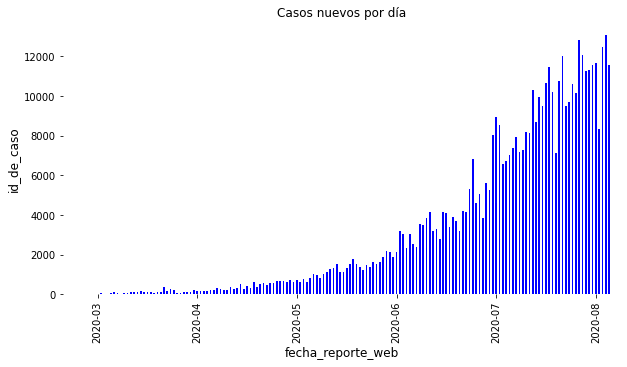

In [61]:
from bokeh.plotting import figure, output_file, show
data_agrupada = consolidated_files.groupby (['fecha_reporte_web']).id_de_caso.count()
ax = data_agrupada.plot.bar(figsize = (10,5), color = 'blue')

ax.set_xlabel("Fecha",  size=12)
ax.set_ylabel("Casos nuevos por día", size=12)
p = figure(x_axis_type='datetime')

x_labels = post_counts.index

sns.barplot(x_labels, post_counts, color="blue")

tick_positions = np.arange(10, len(x_labels), step=30)

plt.xticks(tick_positions, x_labels[tick_positions].strftime("%Y-%m"))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.title("Casos nuevos por día")

### **Casos confirmados**

In [62]:
casos_confirmados = consolidated_files['id_de_caso'].count()
print('El total de casos confirmados es: ',casos_confirmados,)

El total de casos confirmados es:  513719


### **Casos recuperados**

In [63]:
count_gral = consolidated_files[['id_de_caso','atenci_n']]
count_rec = count_gral.loc[count_gral['atenci_n'] == 'Recuperado']
count_rec = pd.DataFrame(count_rec)
count_rec = count_rec['atenci_n'].count()
print('El total de casos recuperados es: ',count_rec,)

El total de casos recuperados es:  339124


In [64]:
print('El porcentaje de recuperados es del:', count_rec/casos_confirmados*100,'%')

El porcentaje de recuperados es del: 66.01352101051353 %


### **Casos fallecidos**

In [65]:
count_fallecidos = count_gral.loc[count_gral['atenci_n'] == 'Fallecido']
count_fallecidos = pd.DataFrame(count_fallecidos)
count_fallecidos = count_fallecidos['atenci_n'].count()
print('El total de casos fallecidos es: ',count_fallecidos,)

El total de casos fallecidos es:  16183


In [66]:
print('El porcentaje de fallecidos es del:', count_fallecidos/casos_confirmados*100,'%')

El porcentaje de fallecidos es del: 3.150165752094044 %


#### **Conteo por estado**

In [67]:
conteo = consolidated_files.groupby('atenci_n').count()
conteo

,Unnamed: 0,id_de_caso,fecha_de_notificaci_n,c_digo_divipola,ciudad_de_ubicaci_n,departamento,edad,sexo,tipo,estado,...,fis,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_de_muerte
atenci_n,,,,,,,,,,,,,,,,,,,,,
Casa,136690,136690,136690,136690,136690,136690,136690,136690,136690,136690,...,136690,136658,0,136690,0,136690,0,3325,741,0
Fallecido,16183,16183,16183,16183,16183,16183,16183,16183,16183,16183,...,16183,15984,0,16183,0,16183,23,11849,253,16183
Hospital,18519,18519,18519,18519,18519,18519,18519,18519,18519,18519,...,18519,18429,0,18519,0,18519,4,8930,203,0
Hospital UCI,2182,2182,2182,2182,2182,2182,2182,2182,2182,2182,...,2182,2165,0,2182,0,2182,0,1397,23,0
Recuperado,339124,339124,339124,339124,339124,339124,339124,339124,339124,339024,...,339124,335641,339124,339124,339124,339124,937,263044,5246,94


In [68]:
conteo_estado = conteo['id_de_caso']
conteo_estado = pd.DataFrame(conteo_estado)

In [69]:
conteo_estado = conteo_estado.sort_values(by='id_de_caso', ascending=False)
conteo_estado

,id_de_caso
atenci_n,
Recuperado,339124
Casa,136690
Hospital,18519
Fallecido,16183
Hospital UCI,2182


En el conteo por estado se observa el comportamiento del total de casos positivos de COVID-19 en Colombia.

Con el fin de tener un panorama detallado de este comportamiento, se evalúan las cinco principales ciudades de Colombia.

### **Ciudades principales**

In [70]:
agr_ciudad = data_filtrada_ciudades.groupby (['ciudad_de_ubicaci_n']).id_de_caso.count()
agr_ciudad = agr_ciudad.to_frame()
agr_ciudad = pd.DataFrame(agr_ciudad)

In [71]:
agr_ciudad.columns = ['Cantidad']

In [72]:
agr_ciudad.sort_values("Cantidad", axis = 0, ascending = True, 
                 inplace = True)
agr_ciudad

,Cantidad
ciudad_de_ubicaci_n,
Cartagena de Indias,18631
Cali,32537
Barranquilla,35127
Medellín,38378
Bogotá D.C.,179540


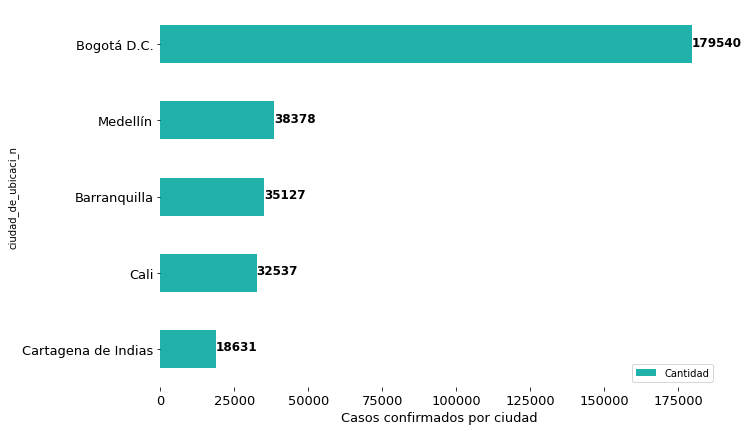

In [73]:
y_label = agr_ciudad[['Cantidad']]
ax = agr_ciudad.plot(kind='barh', figsize=(10,7),
                                        color="lightseagreen", 
                                         fontsize=13);

ax.set_xlabel("Casos confirmados por ciudad",  size=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
for p in ax.patches:
    width = p.get_width()
    plt.text(5+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.0f}'.format(width),
             ha='left', va='center', color='black', fontweight='bold', fontsize=12)

Se identifica que Bogotá D.C., Medellín, Cali, Barranquilla y Cartagena de Indias son las ciudades con mayor número de casos por COVID-19, por lo cual, el análisis descriptivo se enfocará para estas cinco ciudades principales de Colombia.

### **Casos confirmados por edad**

Text(0.5, 1.0, 'Casos confirmados por edad')

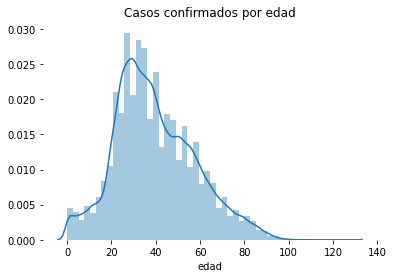

In [74]:
ax = sns.distplot(consolidated_files['edad'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.title("Casos confirmados por edad")

En las cinco ciudades principales de Colombia, se logra observar un incremento de los casos confirmados en un rango de edad entre los 30 y 40 años, y siendo menor en el rango de 70 años en adelante.

### **Fallecidos por edad**

In [75]:
fallecidos_edad = consolidated_files.loc[consolidated_files['atenci_n'].isin(['Fallecido'])] 

Text(0.5, 1.0, 'Fallecidos por edad')

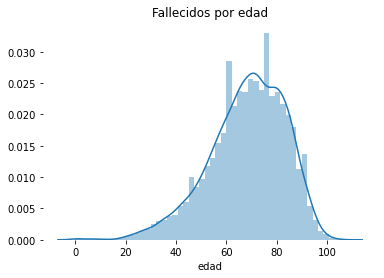

In [76]:
ax = sns.distplot(fallecidos_edad['edad'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.title("Fallecidos por edad")

Si bien se observaba en los casos confirmados por edad un incremento importante en los rango de edad entre 30 y 40 años, en los casos de fallecidos a causa del COVID-19 se observa que el rango de edad de las personas que mueren a causa de la enfermedad se encuentran en el rango de edad entre 70 y 80 años, logrando evidenciar que ésta es la población más vulnerable debido a los antecedentes de salud que puedan presentar y cuentan con una alta probabilidad de agravarse con el virus.

#### **Casos confirmados por sexo**

In [77]:
consolidated_files['sexo'] = consolidated_files['sexo'].str.replace('f','F')
consolidated_files['sexo'] = consolidated_files['sexo'].str.replace('m','M')

In [78]:
sexo_F = consolidated_files[consolidated_files['sexo'] == 'F']
sexo_M = consolidated_files[consolidated_files['sexo'] == 'M']

In [79]:
data_sexo_confirmados= consolidated_files.groupby(["sexo"])["id_de_caso"].count()
data_sexo_confirmados = pd.DataFrame(data_sexo_confirmados)

In [80]:
data_sex_conf = data_sexo_confirmados.T
data_sex_conf = pd.DataFrame(data_sex_conf)

ValueError: x must be 1D

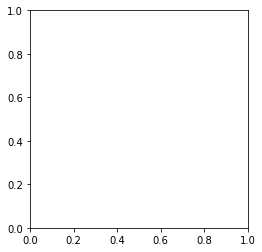

In [81]:
sizes = [15, 30]
colors = ['salmon','lightseagreen']
explode = (0.05,0.05)
plt.pie(data_sexo_confirmados, labels=['Femenino','Masculino'],colors = colors,autopct='%1.1f%%',startangle=90, pctdistance=0.85, explode = explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax.axis('equal')  
plt.tight_layout()
plt.show()

Dentro del grupo poblacional en las cinco principales ciudades de Colombia, se tiene que el mayor porcentaje de casos confirmados corresponden a hombres y en menor proporción corresponde a mujeres.